# Step 1: Importing Libraries & The Original Data

In [9]:
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Data Pre-Processing
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Model Training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model Evaluation
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

sns.set(style = 'whitegrid')
sns.set_context('notebook')

data = pd.read_csv('/content/train.csv')

data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


WORKFLOW

# Step 2: Exploratory Data Analysis: Understanding the Original Data

**We will analyse and plot:**

2.1.   the number of cars per brand to get a feeling of the distirbution of the dataset under the *'brand'* column

2.2.   the distribution of the model year

2.3.   the distribution of the milage

2.4.   the distribution of prices

2.5.   the various fuel types, engines, and transmissions

2.6.   the vehicles with a reported accident vs those that have not reported one


---


# Step 3: Data Cleaning

3.1   removal of redundant features following the EDA

3.2   dropping records with limited statistical importance while ensuring this does not result in a certain class being underrepresented, subsequently leading to an imbalanced dataset

3.3. Missing data under the Engine Volume, HP, and/or Cylinders columns and the car is electric, the former and the latter will be set to 0.


---


# Step 4: Feature Engineering

4.1. We drop the 'clean_title' column since it contains a single unique value across all records and hence adds no value

4.2. We drop the interior and exterior colour columns as they are believed to not add any statistical significance and are irrelevant given the project scope

4.3. categorical brackets for some numeric data to decrease dimensionality

4.4. We create new columns "Engine Volume", "HP", "Cylinders" by using the available data under the 'engine' column where that is applicable


---


# Step 5: Exploring the new features and cleaning if necessary





Number of cars:  188533
Number of brands:  57


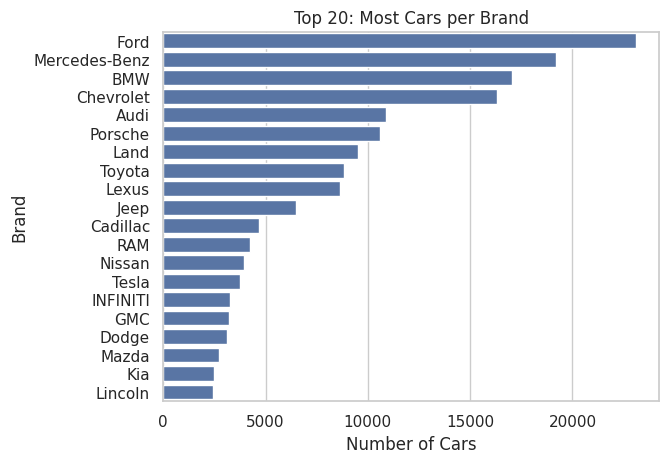

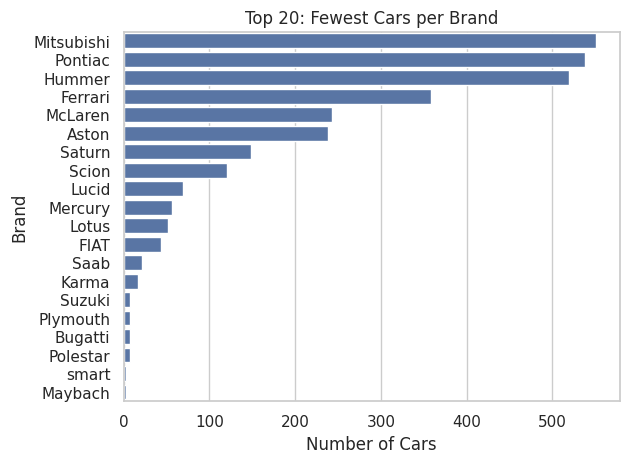

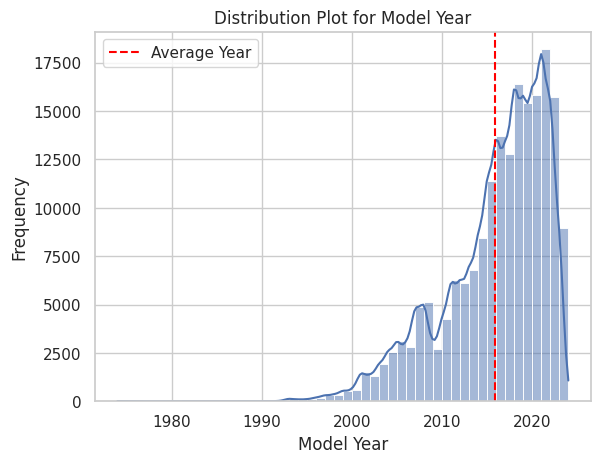

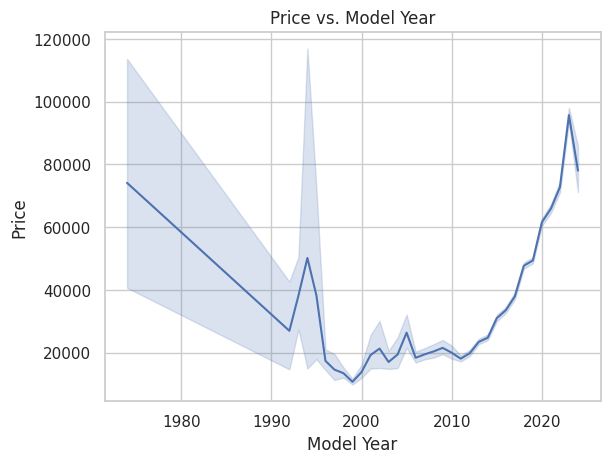

In [19]:
# the 20 brands with the most presence in the dataset
print("Number of cars: ", data.shape[0])
print("Number of brands: ", data['brand'].nunique())

sns.countplot(data = data, y = 'brand', order = data['brand'].value_counts().iloc[:20].index)
plt.title('Top 20: Most Cars per Brand')
plt.xlabel('Number of Cars')
plt.ylabel('Brand')
plt.show()

print('\n')

# the 20 brands with the least presence in the dataset
sns.countplot(data = data, y = 'brand', order = data['brand'].value_counts().iloc[-20:].index)
plt.title('Top 20: Fewest Cars per Brand')
plt.xlabel('Number of Cars')
plt.ylabel('Brand')
plt.show()

print('\n')

# a histogram of the distirbution of the model year
sns.histplot(data['model_year'], kde = True, bins = 50)
plt.axvline(data['model_year'].mean(), color='red', linestyle='--', label = 'Average Year')
plt.title('Distribution Plot for Model Year')
plt.xlabel('Model Year')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# average mileage and price for each brand
brand_avg = data.groupby('brand', as_index = False).agg({'milage': 'mean', 'price': 'mean'})

# interactive plot
fig = px.scatter(brand_avg,
                 text='brand',
                 x='milage',
                 y='price',
                 title='Average Milage vs. Price by Brand',
                 labels={'mileage': 'Average Milage', 'price': 'Average Price'})

# marker size and label position
fig.update_traces(marker = dict(size = 4), textposition = 'top right', textfont_size = 9)
fig.show()

sns.lineplot(data = data, x = 'model_year', y = 'price')
plt.title('Price vs. Model Year')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.show()

In [ ]:
# Define the brackets with an additional bracket extending to infinity
milage_brackets = [100, 25000, 58000, 95000, float('inf')]
milage_labels = ['Low Milage (100-25k)', 'Low-to-Medium Milage (25k-58k)', 'Medium-to-High Milage (58k-95k)', 'High Milage (95k+)']

price_brackets = [2000, 17000, 31000, 50000, float('inf')]
price_labels = ['Low End (2k-17k)', 'Low-to-Medium End (17k-31k)', 'Medium-to-High End (31k-50k)', 'High End (50k+)']

# Apply pd.cut with meaningful labels
data['milage_bracket'] = pd.cut(data['milage'], bins=milage_brackets, labels=milage_labels, include_lowest=True)
data['price_bracket'] = pd.cut(data['price'], bins=price_brackets, labels=price_labels, include_lowest=True)

data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,milage_bracket,price_bracket
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,High Milage (95k+),Low End (2k-17k)
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,High Milage (95k+),Low End (2k-17k)
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability,A/T,Blue,Gray,None reported,Yes,13900,High Milage (95k+),Low End (2k-17k)
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,Low Milage (100-25k),Medium-to-High End (31k-50k)
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,Low Milage (100-25k),High End (50k+)


## Fuel Analysis

We inspect the various types of fuel

In [13]:
data.fuel_type.value_counts()

,count
fuel_type,
Gasoline,165940
Hybrid,6832
E85 Flex Fuel,5406
Diesel,3955
–,781
Plug-In Hybrid,521
not supported,15


In [ ]:
# if within the engine it is mentione the word 'Gasoline'  either upper or lwoer case make the fuel_type Gasoline
data.loc[data['engine'].str.contains('Gasoline', case=False), 'fuel_type'] = 'Gasoline'

In [17]:
data[data['fuel_type'] == '–']['brand'].value_counts()

,count
brand,
Dodge,206
Ford,111
Mazda,61
Toyota,56
Chevrolet,49
Porsche,47
Nissan,38
Chrysler,32
Cadillac,30


In [ ]:
fig = px.scatter(data_frame=data, x='milage', y='price',
                 title='Price vs Milage',
                 labels={'milage': 'Milage', 'price': 'Price'},
                 opacity=0.5)
fig.show()

In [ ]:
data.drop(columns = ['clean_title', 'int_col', 'ext_col'], inplace = True)
data['fuel_type'].fillna('Electric', inplace = True) # filling the missing values in the 'fuel_type' column with 'Electric'
data.loc[(data['brand'] == 'Tesla') & ( (data['fuel_type'] == 'Gasoline') | (data['fuel_type'] == 'Diesel') ), 'fuel_type'] = 'Electric'

# retrieving the HP, engine volume, and cylinders of each vehicle if such information exists under the 'engine' column
data['HP'] = data['engine'].str.extract('(\d+)\.?\d*HP') #fillna('NA')
data['Engine Volume (Liters)'] = data['engine'].str.extract('(\d+\.?\d*)L')
data['Cylinders'] = data['engine'].str.extract('(\d+)\s*Cylinder|V(\d+)').bfill(axis=1).iloc[:, 0]
data.drop(columns = ['engine'], inplace = True)

num_features = ['model_year', 'milage', 'price']
print(f"Dataframe shape: {data.shape}")

print(data.isna().sum(), '\n')

print(data.dtypes, '\n')

data[num_features].describe().apply(lambda s: s.apply('{0:.0f}'.format))

Dataframe shape: (186081, 12)
id                            0
brand                         0
model                         0
model_year                    0
milage                        0
fuel_type                     0
transmission                  0
accident                      0
price                         0
HP                        32428
Engine Volume (Liters)    14078
Cylinders                 21448
dtype: int64 

id                         int64
brand                     object
model                     object
model_year                 int64
milage                     int64
fuel_type                 object
transmission              object
accident                  object
price                      int64
HP                        object
Engine Volume (Liters)    object
Cylinders                 object
dtype: object 



,model_year,milage,price
count,186081,186081,186081
mean,2016,65909,43733
std,6,49830,78462
min,1974,100,2000
25%,2013,24300,17000
50%,2017,57918,30500
75%,2020,95500,49700
max,2024,405000,2954083


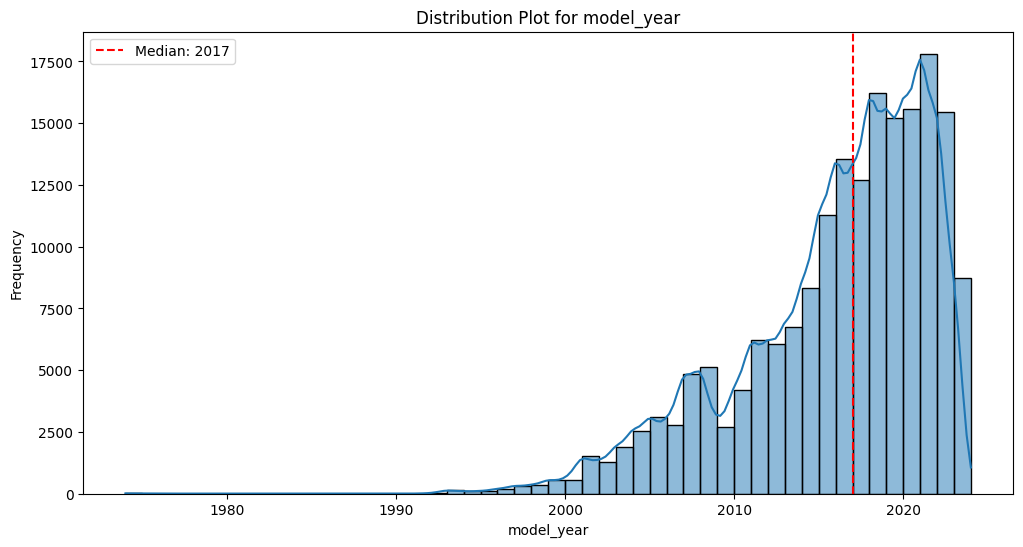

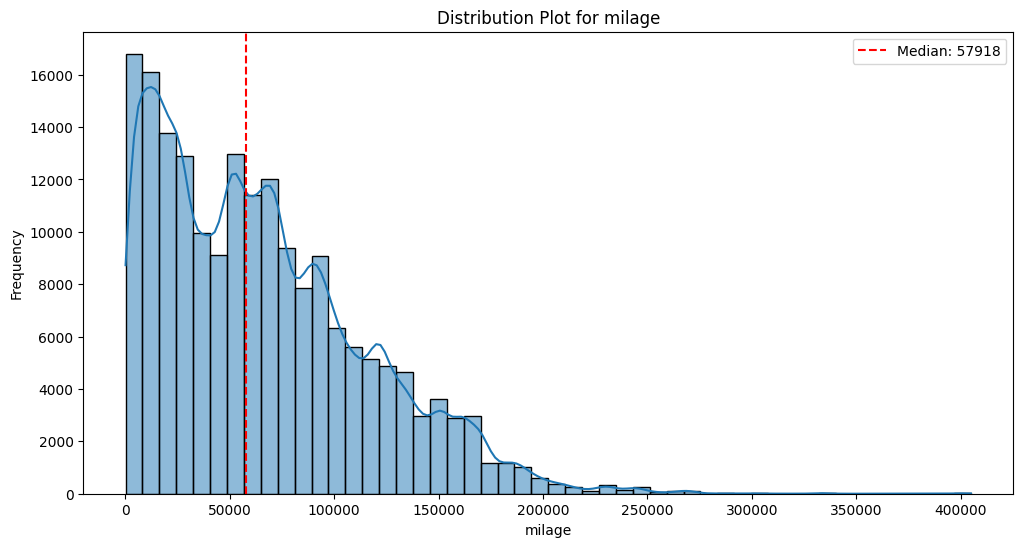

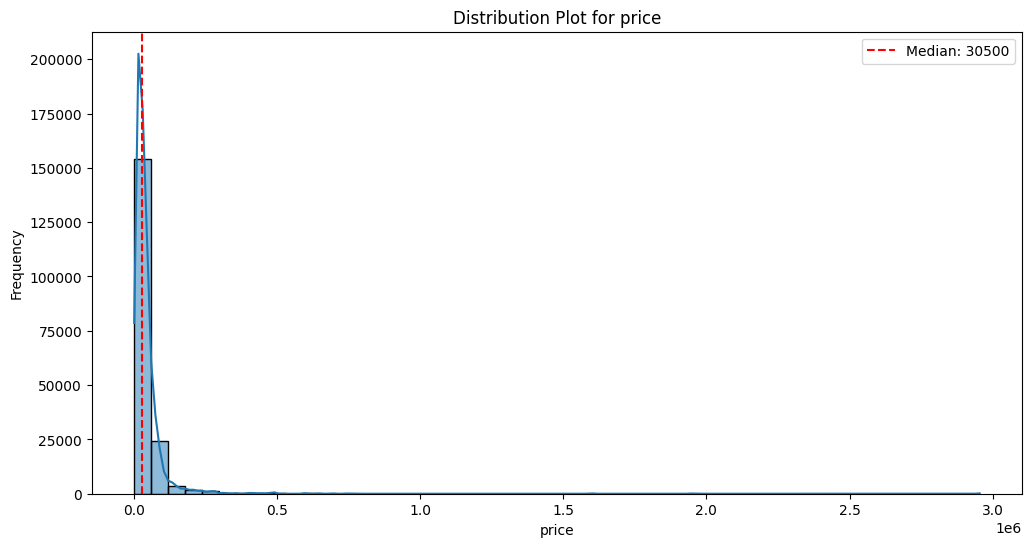

In [ ]:
def plot_numeric_features(df, feature):
  plt.figure(figsize = (12, 6))
  sns.histplot(data[feature], kde = True, bins = 50)
  median_price = data[feature].median().astype(int)
  plt.axvline(median_price, color='red', linestyle='--', label = f'Median: {median_price}')
  plt.title(f'Distribution Plot for {feature}')
  plt.xlabel(f'{feature}')
  plt.ylabel('Frequency')
  plt.legend()
  plt.show()

plot_numeric_features(data, 'model_year')
plot_numeric_features(data, 'milage')
plot_numeric_features(data, 'price')

## Analysing Accidents

Text(0, 0.5, 'Count')

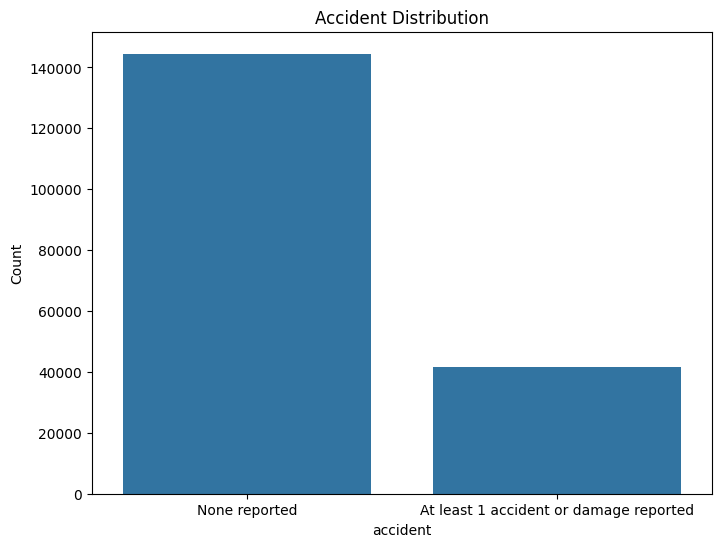

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='accident', data=data)
plt.title('Accident Distribution')
plt.ylabel('Count')

In [ ]:
sns.heatmap(data[num_features].corr(), annot = True)

# Data Pre-Processing & Feature Engineering

1. Handling Outliers

2. Feature Scaling of numeric features & one-hot encoding of categorical features

3. Cross Validation

4. Hyperaparmeter Tuning through GridSearchCV or RandomSearchCV

5. Fit-transform on train data and only transform on test data


## Outlier Removal

In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_out = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_out

df_train_no_outliers = remove_outliers_iqr(data, 'milage')
df_train_no_outliers = remove_outliers_iqr(df_train_no_outliers, 'price')
df_train_no_outliers.reset_index(drop=True, inplace=True)

# Model Training

In [ ]:
# Features and target
X = data.drop(columns = ['price'])
y = data['price']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers = [
        ('num', Pipeline(steps = [
            ('imputer', SimpleImputer(strategy = 'mean')),
            ('scaler', RobustScaler())
        ]), ['model_year', ]),
        ('cat', OneHotEncoder(), ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident'])
    ])

# Creating the model pipeline
model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_jobs = -1))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [ ]:
# Fitting the model
with tqdm(total=1, desc="Training Model") as pbar:
  model.fit(X_train, y_train)
  pbar.update(1)

# Predictions
y_pred = model.predict(X_test)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Training Model:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print("Mean Squared Error:", mse)

importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
print("Feature Importance Ranking:")
for idx in sorted_indices:
    print(f"{X.columns[idx]}: {importances[idx]}")
